In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
# Global Variable for later use

IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
# There are 24826 Images in our Dataset belonging to different diseases associated with Corn, Pepper Bell, Potato and Tomato

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123, # this will ensure we get the same images each time
    shuffle=True, # images inside the batches will be shuffled
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # every image will be of 256x256 dimention
    batch_size=BATCH_SIZE # There will be 32 images in each batch
)

Found 24826 files belonging to 19 classes.


In [4]:
# The Images belong to the following Class Labels

class_names = dataset.class_names
class_names

['Corn Blight',
 'Corn Common_Rust',
 'Corn Gray_Leaf_Spot',
 'Corn Healthy',
 'Pepper_Bell Bacterial_Spot',
 'Pepper_Bell Healthy',
 'Potato Early_Blight',
 'Potato Healthy',
 'Potato Late_Blight',
 'Tomato Bacterial_Spot',
 'Tomato Early_Blight',
 'Tomato Healthy',
 'Tomato Late_Blight',
 'Tomato Leaf_Mold',
 'Tomato Mosaic_Virus',
 'Tomato Septoria_Leaf_Spot',
 'Tomato Spider_Mites',
 'Tomato Target_Spot',
 'Tomato YellowLeaf__Curl_Virus']

In [5]:
# Let's see how the images are distributed inside a batch
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[ 5 18 11  9 17 18 18 18 18 15  5 18 12  5 18 11  5 14  9 12 11 14  1  9
 14 14 10  5  4 18 15 11]


## Visualizing the Dataset

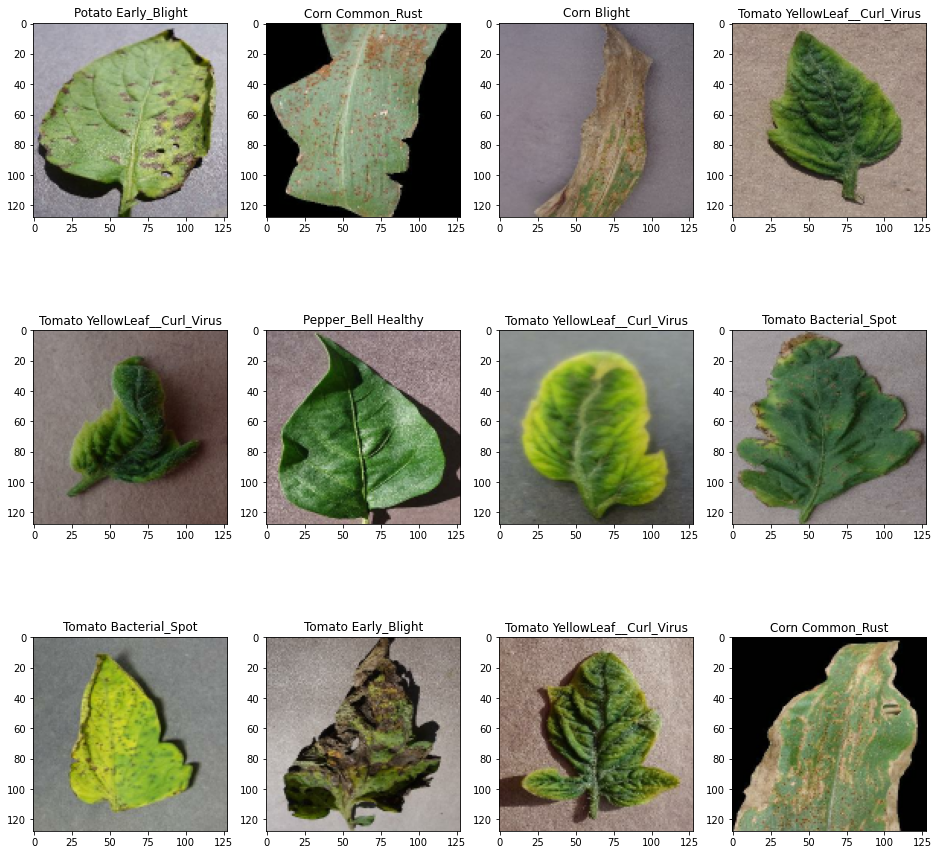

In [6]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

## Splitting the Dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [7]:
# we have 776 batches of data
len(dataset)

776

In [8]:
train_size = 0.80
len(dataset)*train_size

620.8000000000001

In [9]:
train_ds = dataset.take(620)
len(train_ds)

620

In [10]:
test_ds = dataset.skip(620)
len(test_ds)

156

In [11]:
val_size = 0.5
len(test_ds)*val_size

78.0

In [12]:
val_ds = test_ds.take(78)
len(val_ds)

78

In [13]:
test_ds = test_ds.skip(78)
len(test_ds)

78

## Cache, Shuffle, and Prefetch the Dataset

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Image Augmentation
Augmentation is the process of creating new training samples by altering the available data. <br>
It not only increases the number of samples for training the model but also prevents the model from overfitting the training data since it makes relevant feautes in the image location invariant. <br>

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
# Applying Augmentation on Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# Training Batches increased from 620 to 659
len(train_ds)

620

## Designing and Training the Model

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 19

model = tf.keras.Sequential([
    resize_and_rescale,
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [20]:
model.build(input_shape=input_shape)

In [21]:
# There are 1.1 Million Traininable Parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (32, 128, 128, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 127, 127, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 31, 31, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 31, 31, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 10, 10, 64)          0         
_________________________________________________________________
dropout (Dropout)            (32, 10, 10, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 10, 10, 64)         

In [22]:
# Slowing down the learning rate
opt = optimizers.Adam(learning_rate=0.0001)

In [23]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [24]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="plantvillage_weights.h5", verbose=1, save_best_only=True)

In [25]:
history = model.fit(train_ds, epochs = 100, validation_data=val_ds, batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
620/620 [==============================] - 112s 133ms/step - loss: 2.7448 - accuracy: 0.1335 - val_loss: 2.5117 - val_accuracy: 0.1919

Epoch 00001: val_loss improved from inf to 2.51173, saving model to plantvillage_weights.h5
Epoch 2/100
620/620 [==============================] - 59s 95ms/step - loss: 2.3298 - accuracy: 0.2463 - val_loss: 2.0850 - val_accuracy: 0.3269

Epoch 00002: val_loss improved from 2.51173 to 2.08498, saving model to plantvillage_weights.h5
Epoch 3/100
620/620 [==============================] - 60s 96ms/step - loss: 1.9296 - accuracy: 0.3667 - val_loss: 1.7651 - val_accuracy: 0.4119

Epoch 00003: val_loss improved from 2.08498 to 1.76511, saving model to plantvillage_weights.h5
Epoch 4/100
620/620 [==============================] - 61s 99ms/step - loss: 1.6136 - accuracy: 0.4730 - val_loss: 1.4665 - val_accuracy: 0.5136

Epoch 00004: val_loss improved from 1.76511 to 1.46648, saving model to plantvillage_weights.h5
Epoch 5/100
620/620 [=============

620/620 [==============================] - 50s 81ms/step - loss: 0.2402 - accuracy: 0.9197 - val_loss: 0.6973 - val_accuracy: 0.8121

Epoch 00040: val_loss did not improve from 0.46175
Epoch 41/100
620/620 [==============================] - 51s 82ms/step - loss: 0.2364 - accuracy: 0.9190 - val_loss: 0.7536 - val_accuracy: 0.7933

Epoch 00041: val_loss did not improve from 0.46175
Epoch 42/100
620/620 [==============================] - 53s 85ms/step - loss: 0.2318 - accuracy: 0.9241 - val_loss: 0.6721 - val_accuracy: 0.8193

Epoch 00042: val_loss did not improve from 0.46175
Epoch 43/100
620/620 [==============================] - 51s 83ms/step - loss: 0.2188 - accuracy: 0.9263 - val_loss: 0.4192 - val_accuracy: 0.8854

Epoch 00043: val_loss improved from 0.46175 to 0.41919, saving model to plantvillage_weights.h5
Epoch 44/100
620/620 [==============================] - 78s 126ms/step - loss: 0.2213 - accuracy: 0.9259 - val_loss: 0.8074 - val_accuracy: 0.7945

Epoch 00044: val_loss did no

620/620 [==============================] - 52s 84ms/step - loss: 0.1186 - accuracy: 0.9593 - val_loss: 0.4078 - val_accuracy: 0.8954

Epoch 00080: val_loss did not improve from 0.20497
Epoch 81/100
620/620 [==============================] - 51s 83ms/step - loss: 0.1257 - accuracy: 0.9577 - val_loss: 0.6413 - val_accuracy: 0.8610

Epoch 00081: val_loss did not improve from 0.20497
Epoch 82/100
620/620 [==============================] - 50s 80ms/step - loss: 0.1172 - accuracy: 0.9609 - val_loss: 0.3485 - val_accuracy: 0.8930

Epoch 00082: val_loss did not improve from 0.20497
Epoch 83/100
620/620 [==============================] - 49s 79ms/step - loss: 0.1161 - accuracy: 0.9597 - val_loss: 0.5834 - val_accuracy: 0.8694

Epoch 00083: val_loss did not improve from 0.20497
Epoch 84/100
620/620 [==============================] - 49s 79ms/step - loss: 0.1171 - accuracy: 0.9613 - val_loss: 0.4840 - val_accuracy: 0.8982

Epoch 00084: val_loss did not improve from 0.20497
Epoch 85/100
620/620 [=

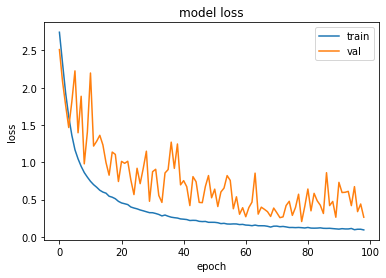

In [31]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

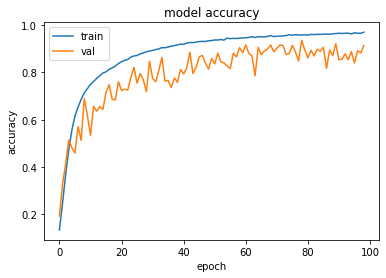

In [32]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("plantvillage_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [29]:
# Load pretrained model (best saved one)
with open('plantvillage_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('plantvillage_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [30]:
scores = model.evaluate(test_ds)

78/78 [==============================] - 28s 19ms/step - loss: 0.2445 - accuracy: 0.9169
